In [2]:
import datetime, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy

from sklearn import metrics, linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy import sparse
from sklearn.metrics import mean_absolute_error, accuracy_score

## Topic 4. Prediction/Correlation


### Hypothesis 1: Predicting departure delay for 4 quarters based on historic data(Linear Regression)

In [1634]:
#2013 year
df1 = pd.read_csv('./flight_delays_2013.csv', low_memory=False)
df1 = df1[df1["DEP_DELAY"] < 1440]
df1 = df1[df1["ARR_DELAY"] < 1440]
#df1 = df1[(df1['MONTH'] >= 4) & (df1['MONTH'] <= 6)]
df1 = df1[(df1['MONTH'] >=10) & (df1['MONTH'] <=12 )]

In [1635]:
#2014 year
df2 = pd.read_csv('./flight_delays_2014.csv', low_memory=False)
df2 = df2[df2["DEP_DELAY"] < 1440]
df2 = df2[df2["ARR_DELAY"] < 1440]
df2 = df2[(df2['MONTH'] >= 10) & (df2['MONTH'] <= 12)]

In [1636]:

# #2015 year
df3 = pd.read_csv('./flight_delays_2015.csv', low_memory=False)
df3 = df3[df3["DEP_DELAY"] < 1440]
df3 = df3[df3["ARR_DELAY"] < 1440]
df3 = df3[(df3['MONTH'] >= 10) & (df3['MONTH'] <= 12)]

In [1637]:
# #2016 year
df4 = pd.read_csv('./flight_delays_2016.csv', low_memory=False)
df4 = df4.drop(['Unnamed: 0'], axis =1)
df4 = df4[df4["DEP_DELAY"] < 1440]
df4 = df4[df4["ARR_DELAY"] < 1440]
df4 = df4[(df4['MONTH'] >= 10) & (df4['MONTH'] <= 12)]

In [1638]:
# #2016 year
df5 = pd.read_csv('./flight_delays_2017.csv', low_memory=False)
df5 = df5[df5["DEP_DELAY"] < 1440]
df5 = df5[df5["ARR_DELAY"] < 1440]
df5 = df5[(df5['MONTH'] >= 10) & (df5['MONTH'] <= 12)]

In [1640]:
def extractquarter1(x):
    t = int(x.split('/')[1])/8
    if  t<=1:
        return 1
    elif t<=2:
        return 2
    elif t<=3:
        return 3
    else:
        return 4

def extractquarter(x):
    t = int(x.split('-')[2])/8
    if  t<=1:
        return 1
    elif t<=2:
        return 2
    elif t<=3:
        return 3
    else:
        return 4

In [1641]:
df1["MONTH_QUARTER"] = df1["FL_DATE"].apply(extractquarter1)
df2["MONTH_QUARTER"] = df2["FL_DATE"].apply(extractquarter1)
df3["MONTH_QUARTER"] = df3["FL_DATE"].apply(extractquarter1)
df4["MONTH_QUARTER"] = df4["FL_DATE"].apply(extractquarter)

In [1642]:
def getWeekDay(df):
    year, month, day = (int(x) for x in df['FL_DATE'].split('-'))    
    answer = datetime.date(year, month, day).weekday()
    return answer

def getWeekDay1(df):
    month, day, year= (int(x) for x in df['FL_DATE'].split('/'))    
    answer = datetime.date(year, month, day).weekday()
    return answer

In [1643]:
df1['DAY_OF_WEEK'] = df1.apply(getWeekDay1,axis =1)
df2['DAY_OF_WEEK'] = df2.apply(getWeekDay1,axis =1)
df3['DAY_OF_WEEK'] = df3.apply(getWeekDay1,axis =1)
df4['DAY_OF_WEEK'] = df4.apply(getWeekDay,axis =1)

In [1644]:
df5['DAY_OF_WEEK'] = df5.apply(getWeekDay1,axis =1)

In [1645]:
df = pd.concat([ df3, df4], axis = 0)

In [1646]:
origin_airports = list(df['ORIGIN'].unique()) + list(df5['ORIGIN'].unique())
dest_airports = list(df['DEST'].unique()) + list(df5['DEST'].unique())

in_first = set(origin_airports)
in_second = set(dest_airports)

in_second_but_not_in_first = in_second - in_first
result_airports = origin_airports + list(in_second_but_not_in_first)

airline_carrier = list(df['CARRIER'].unique())

In [1647]:
#Calcualte the schedule departure, departure time - departure delay
def get_time_in_min(x):
    val = x
    if len(x) == 4:
        pass
    elif len(x) == 3:
        val = '0' + val
    elif len(x) == 2:
        val = '00' + val
    elif len(x) == 1:
        val = '000'+ val
    hours = int(val[:2])*60 
    mins = int(val[2:])
    return hours+mins

def get_hour_from_min(x): 
    return int(x/60)


def get_airport_id(x):
    return result_airports.index(x)

def get_airline_carrier_code(x):
    return airline_carrier.index(x)

def check_for_negative(x):
    if x<0:
        return x+1440
    else:
        return x

In [1648]:
df['SCHEDULE_DEP']  = df['DEP_TIME'].astype('int32')
df['SCHEDULE_DEP']  = df['SCHEDULE_DEP'].astype(str)
df['SCHEDULE_DEP'] = df['SCHEDULE_DEP'].apply(get_time_in_min)
df['SCHEDULE_DEP'] = df['SCHEDULE_DEP'] - df['DEP_DELAY']
df['SCHEDULE_DEP'] = df['SCHEDULE_DEP'].apply(check_for_negative)
df['SCHEDULE_DEP'] = df['SCHEDULE_DEP'].apply(get_hour_from_min)

In [1649]:
df5['SCHEDULE_DEP']  = df5['DEP_TIME'].astype('int32')
df5['SCHEDULE_DEP']  = df5['SCHEDULE_DEP'].astype(str)
df5['SCHEDULE_DEP'] = df5['SCHEDULE_DEP'].apply(get_time_in_min)
df5['SCHEDULE_DEP'] = df5['SCHEDULE_DEP'] - df5['DEP_DELAY']
df5['SCHEDULE_DEP'] = df5['SCHEDULE_DEP'].apply(check_for_negative)
df5['SCHEDULE_DEP'] = df5['SCHEDULE_DEP'].apply(get_hour_from_min)

In [1650]:
df['SCHEDULE_ARR']  = df['ARR_TIME'].astype('int32')
df['SCHEDULE_ARR']  = df['SCHEDULE_ARR'].astype(str)
df['SCHEDULE_ARR'] = df['SCHEDULE_ARR'].apply(get_time_in_min)
df['SCHEDULE_ARR'] = df['SCHEDULE_ARR'] - df['ARR_DELAY']
df['SCHEDULE_ARR'] = df['SCHEDULE_ARR'].apply(check_for_negative)
df['SCHEDULE_ARR'] = df['SCHEDULE_ARR'].apply(get_hour_from_min)

In [1651]:
df5['SCHEDULE_ARR']  = df5['ARR_TIME'].astype('int32')
df5['SCHEDULE_ARR']  = df5['SCHEDULE_ARR'].astype(str)
df5['SCHEDULE_ARR'] = df5['SCHEDULE_ARR'].apply(get_time_in_min)
df5['SCHEDULE_ARR'] = df5['SCHEDULE_ARR'] - df5['ARR_DELAY']
df5['SCHEDULE_ARR'] = df5['SCHEDULE_ARR'].apply(check_for_negative)
df5['SCHEDULE_ARR'] = df5['SCHEDULE_ARR'].apply(get_hour_from_min)

In [1652]:
df['ORIGIN'] = df['ORIGIN'].apply(get_airport_id)
df['DEST'] = df['DEST'].apply(get_airport_id)
df['CARRIER'] = df['CARRIER'].apply(get_airline_carrier_code)

In [1653]:
#df5 = df5.drop(df5[df5.ORIGIN == 'TOL'].index)
df5['ORIGIN'] = df5['ORIGIN'].apply(get_airport_id)
df5['DEST'] = df5['DEST'].apply(get_airport_id)
df5['CARRIER'] = df5['CARRIER'].apply(get_airline_carrier_code)

In [1654]:
df5.loc[df5['SCHEDULE_DEP']<0]
df5.loc[df5['SCHEDULE_ARR']<0]

,YEAR,MONTH,DAY_OF_MONTH,FL_DATE,CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,...,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CARRIER_NAME,DAY_OF_WEEK,SCHEDULE_DEP,SCHEDULE_ARR


In [1655]:
scalingDF = df[['DISTANCE', 'WEATHER_DELAY']].astype('float') # Numerical features
categDF = df[['MONTH', 'DAY_OF_MONTH', 'ORIGIN', 
                    'DEST', 'SCHEDULE_DEP', 
                    'CARRIER', 'DAY_OF_WEEK']]

testscalingDF = df5[['DISTANCE', 'WEATHER_DELAY']].astype('float')
testcategDF = df5[['MONTH', 'DAY_OF_MONTH', 'ORIGIN', 
                    'DEST', 'SCHEDULE_DEP', 
                    'CARRIER', 'DAY_OF_WEEK']]



In [1656]:
categDF = sparse.csr_matrix(categDF)
testcategDF = sparse.csr_matrix(testcategDF)

In [1657]:
scalingDF_sparse = sparse.csr_matrix(scalingDF)
testscalingDF_sparse = sparse.csr_matrix(testscalingDF)

In [1658]:
x_train = sparse.hstack((scalingDF_sparse, categDF)).toarray()
y_train = df['DEP_DELAY'].values

#x_test = sparse.hstack((testscalingDF_sparse, testcategDF_encoded)).toarray()

In [1659]:
x_test = sparse.hstack((testscalingDF_sparse, testcategDF)).toarray()

In [1660]:
x_train_numerical = x_train[:, 0:2] # We only want the first two features which are the numerical ones.

In [1661]:
x_test_numerical = x_test[:,0:2]

In [1662]:
scaler = MinMaxScaler() # create scaler object
scaler.fit(x_train_numerical) # fit with the training data ONLY
x_train_numerical = sparse.csr_matrix(scaler.transform(x_train_numerical)).toarray() # Transform the data and convert to sparse
x_test_numerical = sparse.csr_matrix(scaler.transform(x_test_numerical)).toarray()

In [1663]:
x_train[:, 0:2] = x_train_numerical

In [1664]:
x_test[:, 0:2] = x_test_numerical

In [1665]:
x_train.shape

(411611, 9)

In [1666]:
x_test.shape

(236478, 9)

In [1667]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

In [1668]:
y_test = df5['DEP_DELAY'].values

In [1669]:
print(mean_absolute_error(y_test, y_pred))

43.89610842189824


In [1670]:
r = copy.deepcopy(df5)

In [1671]:
df5['DEP_DELAY'] = y_pred

In [1672]:
df5 = df5.groupby(['DAY_OF_MONTH'])['DEP_DELAY'].mean()

In [1673]:
l = list(range(1, 32))

In [1674]:
r = r.groupby(['DAY_OF_MONTH'])['DEP_DELAY'].mean()

## For 4th quarter

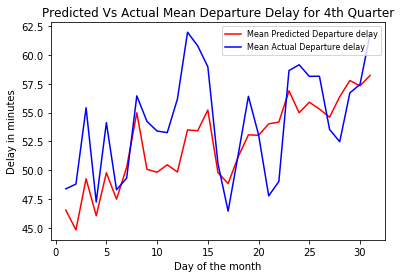

In [1675]:
plt.plot(l,df5.values, 'r')
plt.plot(l, r.values, 'b')
plt.legend(['Mean Predicted Departure delay', 'Mean Actual Departure delay'], loc ='upper right', prop={'size': 8
                                                                                                        })
plt.xlabel('Day of the month')
plt.ylabel('Delay in minutes')
plt.title('Predicted Vs Actual Mean Departure Delay for 4th Quarter')
plt.show()

## For 3rd quarter

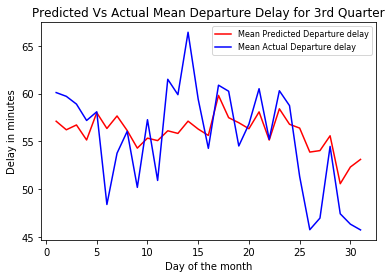

In [1632]:
plt.plot(l,df5.values, 'r')
plt.plot(l, r.values, 'b')
plt.legend(['Mean Predicted Departure delay', 'Mean Actual Departure delay'], loc ='upper right', prop={'size': 8
                                                                                                        })
plt.xlabel('Day of the month')
plt.ylabel('Delay in minutes')
plt.title('Predicted Vs Actual Mean Departure Delay for 3rd Quarter')
plt.show()

## For 2nd quarter

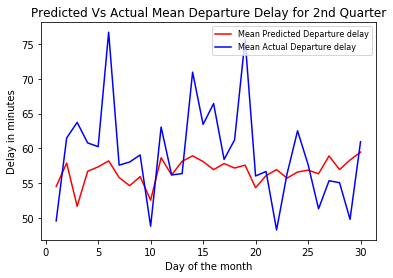

In [1586]:
plt.plot(l,df5.values, 'r')
plt.plot(l, r.values, 'b')
plt.legend(['Mean Predicted Departure delay', 'Mean Actual Departure delay'], loc ='upper right', prop={'size': 8
                                                                                                        })
plt.xlabel('Day of the month')
plt.ylabel('Delay in minutes')
plt.title('Predicted Vs Actual Mean Departure Delay for 2nd Quarter')
plt.show()

## For 1st quarter

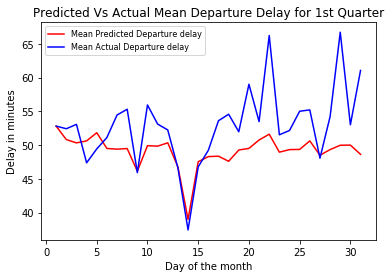

In [1541]:
plt.plot(l,df5.values, 'r')
plt.plot(l, r.values, 'b')
plt.legend(['Mean Predicted Departure delay', 'Mean Actual Departure delay'], loc ='upper left', prop={'size': 8
                                                                                                        })
plt.xlabel('Day of the month')
plt.ylabel('Delay in minutes')
plt.title('Predicted Vs Actual Mean Departure Delay for 1st Quarter')
plt.show()

### Hypothesis 2: Predicting delays for 2018, based on 2011-2017 data (Time Series Analysis)

In [3]:
def calculate_mape2(prediction_y, actual_y):
    total =0
    for i in range(len(actual_y)):
        if actual_y[i] != 0:
            total+= abs(prediction_y[i]-actual_y[i])/ actual_y[i]
    return (total * (100/len(actual_y)))

def ewma(t, alpha):
    sum = 0
    sum += alpha*total[t-1]
    temp = 1-alpha
    for i in range(t-1)[::-1]:
        sum += temp*alpha*total[i]
        temp*=temp
    return sum

In [5]:
data_jan = pd.read_csv('flight_delay_prediction/Data/2011.csv', delimiter=',')

In [7]:
jan_2012_ny = data_jan.loc[(data_jan['ORIGIN_STATE_NM'] == 'New York')]
jan_2012_ny = jan_2012_ny.drop(['Unnamed: 5', 'MONTH', 'YEAR'],axis = 1)
jj = jan_2012_ny.loc[jan_2012_ny['WEATHER_DELAY']!=0]
jj = jj.sort_values('DAY_OF_MONTH')
j = jj.groupby(['DAY_OF_MONTH'])['WEATHER_DELAY'].mean()
j.loc[3] = 0
j.loc[14] = 0
j.loc[16] = 0
j.loc[20] = 0
j.loc[31] = 0
s = pd.DataFrame(j)
s = s.reset_index()
s = s.sort_values('DAY_OF_MONTH')
s = s.reset_index()
s = s.drop(['index'],axis = 1)

d_2011 = s

d_2011 = d_2011.rename(columns = {'WEATHER_DELAY':'WD_2011'})
d_2011 = d_2011.drop(['DAY_OF_MONTH'],axis=1)
data_jan = pd.read_csv('flight_delay_prediction/Data/2012.csv', delimiter=',')
jan_2012_ny = data_jan.loc[(data_jan['ORIGIN_STATE_NM'] == 'New York')]
jan_2012_ny = jan_2012_ny.drop(['Unnamed: 5', 'MONTH', 'YEAR'],axis = 1)
jj = jan_2012_ny.loc[jan_2012_ny['WEATHER_DELAY']!=0]
jj = jj.sort_values('DAY_OF_MONTH')
j = jj.groupby(['DAY_OF_MONTH'])['WEATHER_DELAY'].mean()

j.loc[1] = 0
j.loc[6] = 0
j.loc[7] = 0
j.loc[9] = 0
j.loc[11] = 0
j.loc[24] = 0
j.loc[25] = 0
j.loc[28] = 0
j.loc[31] = 0
s = pd.DataFrame(j)
s = s.reset_index()
s = s.sort_values('DAY_OF_MONTH')
s = s.reset_index()
s = s.drop(['index'],axis = 1)
d_2012 = s
d_2012 = d_2012.rename(columns = {'WEATHER_DELAY':'WD_2012'})
d_2012 = d_2012.drop(['DAY_OF_MONTH'],axis=1)

In [8]:
d_2013 = pd.read_csv('flight_delay_prediction/Data/flight_delays_2013.csv', delimiter=',')

In [9]:
jan_2013_ny = d_2013.loc[(d_2013['MONTH'] == 1) & (d_2013['ORIGIN_STATE_NM'] == 'New York')]

In [10]:
jan_2013_ny = jan_2013_ny.drop(['CARRIER', 'FL_NUM',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'NAS_DELAY', 
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_NAME'],axis = 1)

In [11]:
jj = jan_2013_ny.loc[jan_2013_ny['WEATHER_DELAY']!=0]

In [12]:
jj = jj.sort_values('DAY_OF_MONTH')

In [14]:
j = jj.groupby(['DAY_OF_MONTH'])['WEATHER_DELAY'].mean()
j.loc[7] = 0
j.loc[9] = 0
j.loc[10] = 0
j.loc[11] = 0
j.loc[15] = 0
s = pd.DataFrame(j)
s = s.reset_index()
d_2013 = s

d_2014 = pd.read_csv('flight_delay_prediction/Data/flight_delays_2014.csv', delimiter=',')
j.loc[13] = 0
j.loc[14] = 0
j.loc[17] = 0
s = pd.DataFrame(j)
s = s.reset_index()
s = s.sort_values('DAY_OF_MONTH')
s = s.reset_index()
s = s.drop(['index'],axis = 1)
d_2014 = s

In [18]:
d_2015 = pd.read_csv('flight_delay_prediction/Data/flight_delays_2015.csv', delimiter=',')
jan_2015_ny = d_2015.loc[(d_2015['MONTH'] == 1) & (d_2015['ORIGIN_STATE_NM'] == 'New York')]
jan_2015_ny = jan_2015_ny.drop(['FL_DATE', 'CARRIER', 'FL_NUM',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'NAS_DELAY', 
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_NAME'],axis = 1)
jj = jan_2015_ny.loc[jan_2015_ny['WEATHER_DELAY']!=0]
jj = jj.sort_values('DAY_OF_MONTH')
j = jj.groupby(['DAY_OF_MONTH'])['WEATHER_DELAY'].mean()

j.loc[11] = 0
j.loc[16] = 0
j.loc[17] = 0
j.loc[20] = 0
j.loc[25] = 0

In [19]:
s = pd.DataFrame(j)
s = s.reset_index()
s = s.sort_values('DAY_OF_MONTH')
s = s.reset_index()
s = s.drop(['index'],axis = 1)

d_2015 = s

d_2016 = pd.read_csv('flight_delay_prediction/Data/flight_delays_2016.csv', delimiter=',')
jan_2016_ny = d_2016.loc[(d_2016['MONTH'] == 1) & (d_2016['ORIGIN_STATE_NM'] == 'New York')]
jan_2016_ny = jan_2016_ny.drop(['FL_DATE', 'CARRIER', 'FL_NUM',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'NAS_DELAY', 
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_NAME'],axis = 1)
jj = jan_2016_ny.loc[jan_2016_ny['WEATHER_DELAY']!=0]
jj = jj.sort_values('DAY_OF_MONTH')
j = jj.groupby(['DAY_OF_MONTH'])['WEATHER_DELAY'].mean()

j.loc[1] = 0
j.loc[4] = 0
j.loc[7] = 0
j.loc[9] = 0
j.loc[12] = 0
j.loc[14] = 0
j.loc[15] = 0
j.loc[20] = 0
j.loc[26] = 0
j.loc[27] = 0
j.loc[30] = 0
j.loc[31] = 0

s = pd.DataFrame(j)
s = s.reset_index()
s = s.sort_values('DAY_OF_MONTH')
s = s.reset_index()
s = s.drop(['index'],axis = 1)

d_2016 = s

In [20]:
d_2017 = pd.read_csv('flight_delay_prediction/Data/flight_delays_2017.csv', delimiter=',')
jan_2017_ny = d_2017.loc[(d_2017['MONTH'] == 1) & (d_2017['ORIGIN_STATE_NM'] == 'New York')]
jan_2017_ny = jan_2017_ny.drop(['FL_DATE', 'CARRIER', 'FL_NUM',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'NAS_DELAY', 
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_NAME'],axis = 1)
jj = jan_2017_ny.loc[jan_2017_ny['WEATHER_DELAY']!=0]
jj = jj.sort_values('DAY_OF_MONTH')
j = jj.groupby(['DAY_OF_MONTH'])['WEATHER_DELAY'].mean()
j.loc[19] = 0
j.loc[26] = 0
j.loc[28] = 0
j.loc[29] = 0

s = pd.DataFrame(j)
s = s.reset_index()
s = s.sort_values('DAY_OF_MONTH')
s = s.reset_index()
s = s.drop(['index'],axis = 1)

d_2017 = s

d_2013 = d_2013.rename(columns = {'WEATHER_DELAY':'WD_2013'})
d_2014 = d_2014.rename(columns = {'WEATHER_DELAY':'WD_2014'})
d_2015 = d_2015.rename(columns = {'WEATHER_DELAY':'WD_2015'})
d_2016 = d_2016.rename(columns = {'WEATHER_DELAY':'WD_2016'})
d_2017 = d_2017.rename(columns = {'WEATHER_DELAY':'WD_2017'})

d_2013 = d_2013.drop(['DAY_OF_MONTH'],axis=1)
d_2014 = d_2014.drop(['DAY_OF_MONTH'],axis=1)
d_2015 = d_2015.drop(['DAY_OF_MONTH'],axis=1)
d_2016 = d_2016.drop(['DAY_OF_MONTH'],axis=1)
d_2017 = d_2017.drop(['DAY_OF_MONTH'],axis=1)

result = pd.concat([d_2011, d_2012, d_2013, d_2014, d_2015, d_2016,d_2017], axis = 1)

d11 = list(result['WD_2011'])
d12 = list(result['WD_2012'])
d13 = list(result['WD_2013'])
d14 = list(result['WD_2014'])
d15 = list(result['WD_2015'])
d16 = list(result['WD_2016'])
d17 = list(result['WD_2017'])

total = d11+d12+d13+d14+d15+d16+d17
len(total)



217

Average Error : 14.419800596601862


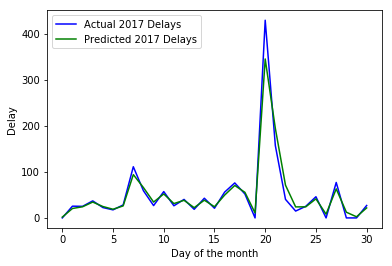

In [22]:
list_ans = []
err = 0
for i in range(0,31):
    result = ewma(186+i,0.8)
    list_ans.append(result)
per_error = calculate_mape2(list_ans,total[185:216])
print("Average Error :",per_error)
plt.plot(total[185:216],color = "blue", label="Actual 2017 Delays")
plt.plot(list_ans,color = "green",label="Predicted 2017 Delays")
plt.legend(loc='upper left')
plt.xlabel("Day of the month")
plt.ylabel("Delay")
plt.show()